

# Project:  Analayzing European Football leagues

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This soccer database comes from Kaggle and is well suited for data analysis of the european football league. It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016. 
In this project, we will explore and analyze the dataset to gain insights and answer some very intersting information such as :

- Top 10 rated players yearly and the top average rated players from 2007-2016.
- Top rated leagues and Top  rated teams between 2008-2016.
- Top teams between 2008-2016 with the most goal differnce playing home, away and in total.
- Top teams between 2008-2016 with the most number and percentage of match wins playing home, away and in total.


>

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, we will load in the data, check for cleanliness, and then trim and clean the dataset for analysis. 


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy
import seaborn as sb
%matplotlib inline

In [2]:
#Establishing connection to the sqlite database.
conn = sqlite3.connect('football_db.sqlite')
c = conn.cursor()



First of all, we have to connect to the database to be able to access it and use queries to access the tables in the database

In [3]:
list_of_tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
list_of_tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...
8,table,League_ratings,League_ratings,306375,"CREATE TABLE League_ratings(\n name TEXT,\n ..."
9,table,League_potential,League_potential,313633,"CREATE TABLE League_potential(\n name TEXT,\n..."


There is a total of 8 tables in the database.

In [4]:
df_leaguematches = pd.read_sql('''SELECT l.name as league, m.season, ht.team_long_name as home_team, at.team_long_name as away_team, 
                                    m.home_team_goal,m.away_team_goal
                                    FROM League l 
                                    JOIN Match m on l.id = m.league_id
                                    JOIN Team ht on ht.team_api_id = m.home_team_api_id
                                    JOIN Team at on at.team_api_id = m.away_team_api_id;''',conn)
print(df_leaguematches.shape)


(25979, 6)


In [5]:
df_leaguematches.head()

,league,season,home_team,away_team,home_team_goal,away_team_goal
0,Belgium Jupiler League,2008/2009,KRC Genk,Beerschot AC,1,1
1,Belgium Jupiler League,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium Jupiler League,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium Jupiler League,2008/2009,KAA Gent,RAEC Mons,5,0
4,Belgium Jupiler League,2008/2009,FCV Dender EH,Standard de Liège,1,3


This is the first dataframe we are going to use to get stats regarding the league and teams. We can get information related to number of goals scored in each league and compare differnt leagues. Same can be applied to teams. We can also compare the teams results throughout the time period (2008-2016). But first, we need to ensure the data is ready for analysis.

In [6]:
print(df_leaguematches.info())
print(50*'-')
print("Missing values of table:")
print(df_leaguematches.isnull().sum().sum())
print(50*'-')
print(df_leaguematches.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   league          25979 non-null  object
 1   season          25979 non-null  object
 2   home_team       25979 non-null  object
 3   away_team       25979 non-null  object
 4   home_team_goal  25979 non-null  int64 
 5   away_team_goal  25979 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB
None
--------------------------------------------------
Missing values of table:
0
--------------------------------------------------
       home_team_goal  away_team_goal
count    25979.000000    25979.000000
mean         1.544594        1.160938
std          1.297158        1.142110
min          0.000000        0.000000
25%          1.000000        0.000000
50%          1.000000        1.000000
75%          2.000000        2.000000
max         10.000000        9.000000


This dataframe looks ready for analysis. There are no null or missing vlaues and data is clean. 


In [7]:
df_league_rating = pd.read_sql('''SELECT l.name, m.season, ht.team_long_name as Teams, yp1.rating as player1_rating, yp2.rating as player2_rating, 
                                yp3.rating as player3_rating, yp4.rating as player4_rating, yp5.rating as player5_rating, yp6.rating as player6_rating,
                                yp7.rating as player7_rating, yp8.rating as player8_rating, yp9.rating as player9_rating, yp10.rating as player10_rating,
                                yp11.rating as player11_rating
                                FROM Match m  
                                LEFT JOIN League l on l.id = m.league_id
                                LEFT JOIN Team ht on m.home_team_api_id = ht.team_api_id
                                LEFT JOIN yearly_Player_ratings yp1 on yp1.player_api_id = m.home_player_1 and yp1.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp2 on yp2.player_api_id = m.home_player_2 and yp2.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp3 on yp3.player_api_id = m.home_player_3 and yp3.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp4 on yp4.player_api_id = m.home_player_4 and yp4.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp5 on yp5.player_api_id = m.home_player_5 and yp5.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp6 on yp6.player_api_id = m.home_player_6 and yp6.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp7 on yp7.player_api_id = m.home_player_7 and yp7.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp8 on yp8.player_api_id = m.home_player_8 and yp8.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp9 on yp9.player_api_id = m.home_player_9 and yp9.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp10 on yp10.player_api_id = m.home_player_10 and yp10.Year = cast(m.date as date)
                                LEFT JOIN yearly_player_ratings yp11 on yp11.player_api_id = m.home_player_11 and yp11.Year = cast(m.date as date)''',conn)

This is the second dataframe we are going to use it to get the league and teams ratings. We can get the team and league ratings by getting the average ratings of all the players that played mathces in their respective teams and leagues. This was the most challenging query to obtain and it took some while to get the query right. 

In [8]:
print(df_league_rating.shape)
df_league_rating.head()

(25979, 14)


,name,season,Teams,player1_rating,player2_rating,player3_rating,player4_rating,player5_rating,player6_rating,player7_rating,player8_rating,player9_rating,player10_rating,player11_rating
0,Belgium Jupiler League,2008/2009,KRC Genk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Belgium Jupiler League,2008/2009,SV Zulte-Waregem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Belgium Jupiler League,2008/2009,KSV Cercle Brugge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Belgium Jupiler League,2008/2009,KAA Gent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Belgium Jupiler League,2008/2009,FCV Dender EH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print(df_league_rating.info())
print(50*'-')
print("Missing values of table:")
print(df_league_rating.isnull().sum().sum())
print(50*'-')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             25979 non-null  object 
 1   season           25979 non-null  object 
 2   Teams            25979 non-null  object 
 3   player1_rating   24128 non-null  float64
 4   player2_rating   23991 non-null  float64
 5   player3_rating   24189 non-null  float64
 6   player4_rating   24054 non-null  float64
 7   player5_rating   24157 non-null  float64
 8   player6_rating   24196 non-null  float64
 9   player7_rating   24339 non-null  float64
 10  player8_rating   24218 non-null  float64
 11  player9_rating   24337 non-null  float64
 12  player10_rating  24130 non-null  float64
 13  player11_rating  24030 non-null  float64
dtypes: float64(11), object(3)
memory usage: 2.8+ MB
None
--------------------------------------------------
Missing values of table:
20000
---------------

There are alot of missing and null values this dataframe needs alot of cleaning to remove the get rid of the null values.

In [10]:
df_league_rating['overall_rating']=df_league_rating.iloc[:,3:14].mean(axis=1)
df_league_rating.overall_rating.isna().sum()


766

A new column (overall_rating) is inserted. This contains the average rating of the 11 players of a team at each match. We would use this column to fill some missing values of players.
However, we cannot use this value if the whole players of a team are missing. In this case, we would just drop the whole row. 

In [11]:
df_league_rating['player1_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player2_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player3_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player4_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player5_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player6_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player7_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player8_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player9_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player10_rating'].fillna(df_league_rating.overall_rating, inplace=True)
df_league_rating['player11_rating'].fillna(df_league_rating.overall_rating, inplace=True)



The overall_rating value is used to fill the null values for the missing players.

In [12]:
df_league_rating.isna().sum().sum()

9192

In [13]:

df_league_rating.dropna(axis=0, inplace=True)
df_league_rating.head()


,name,season,Teams,player1_rating,player2_rating,player3_rating,player4_rating,player5_rating,player6_rating,player7_rating,player8_rating,player9_rating,player10_rating,player11_rating,overall_rating
144,Belgium Jupiler League,2008/2009,Royal Excel Mouscron,66.50,64.0,63.0,62.0,64.0,64.0,64.0,64.0,65.0,64.0,63.5,64.00
145,Belgium Jupiler League,2008/2009,KV Mechelen,61.00,58.5,68.0,58.0,64.0,61.8,62.0,66.0,52.5,65.0,63.0,61.80
146,Belgium Jupiler League,2008/2009,Sporting Charleroi,64.50,64.5,64.5,68.0,63.0,64.5,61.0,64.5,65.0,68.0,62.0,64.50
147,Belgium Jupiler League,2008/2009,Standard de Liège,72.45,74.0,76.0,67.0,72.0,64.0,72.5,77.0,75.0,71.5,75.5,72.45
148,Belgium Jupiler League,2008/2009,Sporting Lokeren,73.00,68.0,67.0,64.0,64.5,68.0,64.0,64.0,65.0,66.9,71.5,66.90


There are rows in which all the players ratings are missing, in this case, we have no choice except to remove the whole row.

In [14]:
df_league_rating.reset_index(inplace=True)
df_league_rating.drop(['index'],axis=1)

,name,season,Teams,player1_rating,player2_rating,player3_rating,player4_rating,player5_rating,player6_rating,player7_rating,player8_rating,player9_rating,player10_rating,player11_rating,overall_rating
0,Belgium Jupiler League,2008/2009,Royal Excel Mouscron,66.50,64.0,63.0,62.0,64.0,64.0,64.0,64.0,65.0,64.0,63.5,64.000000
1,Belgium Jupiler League,2008/2009,KV Mechelen,61.00,58.5,68.0,58.0,64.0,61.8,62.0,66.0,52.5,65.0,63.0,61.800000
2,Belgium Jupiler League,2008/2009,Sporting Charleroi,64.50,64.5,64.5,68.0,63.0,64.5,61.0,64.5,65.0,68.0,62.0,64.500000
3,Belgium Jupiler League,2008/2009,Standard de Liège,72.45,74.0,76.0,67.0,72.0,64.0,72.5,77.0,75.0,71.5,75.5,72.450000
4,Belgium Jupiler League,2008/2009,Sporting Lokeren,73.00,68.0,67.0,64.0,64.5,68.0,64.0,64.0,65.0,66.9,71.5,66.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25208,Switzerland Super League,2015/2016,FC St. Gallen,61.50,52.7,62.7,55.1,65.0,58.9,62.5,61.6,64.6,65.1,59.0,60.790909
25209,Switzerland Super League,2015/2016,FC Vaduz,62.00,56.5,60.8,58.0,58.5,61.7,62.0,59.3,61.6,54.3,56.0,59.154545
25210,Switzerland Super League,2015/2016,Grasshopper Club Zürich,66.10,58.5,62.8,64.9,61.6,76.7,66.7,69.0,61.0,71.0,70.5,66.254545
25211,Switzerland Super League,2015/2016,Lugano,60.55,64.0,64.0,53.0,61.3,60.5,59.0,64.7,60.0,57.5,61.5,60.550000


The dataframe is now ready for analysis after we filled and removed the null values.

In [15]:
df_player_rating = pd.read_sql (''' SELECT pa.player_api_id, p.player_name, round(avg(pa.overall_rating),1) as rating, CAST(pa.date as date) as Year
                                    FROM Player_Attributes pa
                                    JOIN Player p on p.player_api_id = pa.player_api_id
                                    group by pa.player_api_id, CAST(pa.date as date)''',conn)

In this dataframe, we will be looking to find the top rated players for each year and their average ratings for all years between 2007-2016

In [16]:
df_player_rating.head()

,player_api_id,player_name,rating,Year
0,2625,"Patryk Rachwal,18",63.0,2007
1,2625,"Patryk Rachwal,18",60.0,2008
2,2625,"Patryk Rachwal,18",60.0,2010
3,2625,"Patryk Rachwal,18",58.5,2011
4,2625,"Patryk Rachwal,18",58.0,2012


In [17]:
print(df_player_rating.info())
print(50*'-')
print("Missing values of table:")
print(df_player_rating.isnull().sum().sum())
print(50*'-')
print(df_player_rating.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73059 entries, 0 to 73058
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_api_id  73059 non-null  int64  
 1   player_name    73059 non-null  object 
 2   rating         73059 non-null  float64
 3   Year           73059 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.2+ MB
None
--------------------------------------------------
Missing values of table:
0
--------------------------------------------------
       player_api_id        rating          Year
count   73059.000000  73059.000000  73059.000000
mean   126788.151261     67.229770   2011.340095
std    133346.086777      7.349904      2.907770
min      2625.000000     33.000000   2007.000000
25%     33775.000000     62.800000   2009.000000
50%     68861.000000     67.000000   2011.000000
75%    181197.000000     72.000000   2014.000000
max    750584.000000     94.000000   201

This dataframe is clean and is ready for analysis.

<a id ='eda'></a>
## Exploratory Data Analysis


### Who are the top 10 rated players yearly and the top average rated players from 2007-2016.

In [18]:
player_rating = df_player_rating.drop(['player_api_id'], axis=1)
player_rating.head()


,player_name,rating,Year
0,"Patryk Rachwal,18",63.0,2007
1,"Patryk Rachwal,18",60.0,2008
2,"Patryk Rachwal,18",60.0,2010
3,"Patryk Rachwal,18",58.5,2011
4,"Patryk Rachwal,18",58.0,2012


The 'player_api_id' column is dropped since we do not need it in our analysis.

In [19]:
# We Get the index of the top player for each year
yearly_top_idx = player_rating.groupby(by=['Year'])['rating'].idxmax().values
yearly_top_idx

array([13821, 13514, 13515, 14996, 14997, 14998, 14999, 15000, 15001,
        2693], dtype=int64)

In [20]:
player_rating.iloc[yearly_top_idx]

,player_name,rating,Year
13821,Gianluigi Buffon,92.0,2007
13514,Iker Casillas,91.0,2008
13515,Iker Casillas,90.5,2009
14996,Lionel Messi,90.0,2010
14997,Lionel Messi,92.0,2011
14998,Lionel Messi,94.0,2012
14999,Lionel Messi,94.0,2013
15000,Lionel Messi,93.3,2014
15001,Lionel Messi,93.4,2015
2693,Neymar,90.0,2016


This is the top rated player for each year.
However, there is alot of missing players ratings in the year 2016 where the ratings of many top players is not present.

In [21]:
# We get the top 10 average players rating from 2007 till 2016.
player_avg_rating =player_rating.groupby(by='player_name').mean()
player_avg_rating.sort_values(by='rating', ascending=False, inplace=True)
player_avg_rating.drop(['Year'], axis=1, inplace=True)
player_avg_rating =player_avg_rating.round(decimals=1)
player_avg_rating.head(10)

,rating
player_name,
Lionel Messi,91.4
Cristiano Ronaldo,90.8
Zlatan Ibrahimovic,88.1
Franck Ribery,87.8
Wayne Rooney,87.7
Andres Iniesta,87.6
Xavi Hernandez,87.6
Iker Casillas,87.5
Arjen Robben,87.5


The average ratings for the top 10 players from 2008 to 2016. The only 2 players who exceeded the 90 rating are lionel Messi and Cristiano Ronaldo.

<AxesSubplot: title={'center': 'Top 10 Average Players Ratings 2007 - 2016'}, xlabel='player_name', ylabel='Overall Average Rating'>

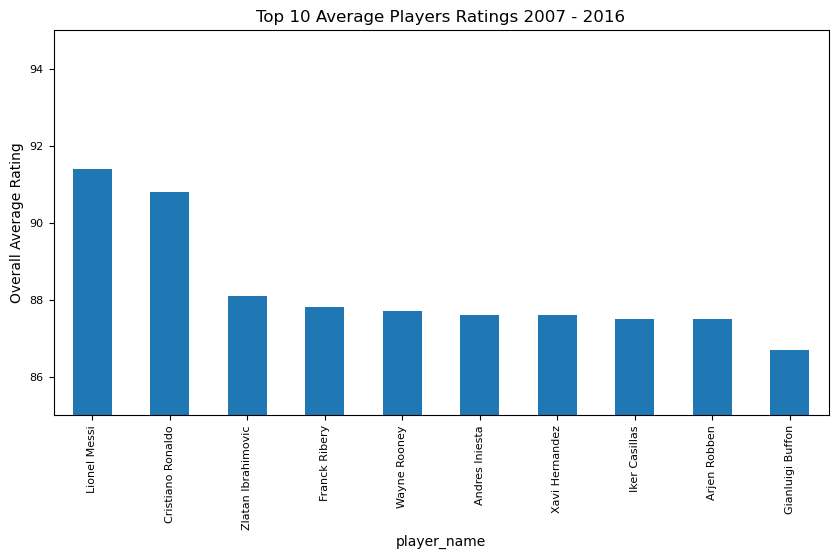

In [22]:
player_avg_rating.head(10).plot(figsize= (10,5), xlabel=None, ylabel='Overall Average Rating', fontsize=8, kind='bar', ylim=(85,95), legend=None, title= 'Top 10 Average Players Ratings 2007 - 2016')


The top average rated player from 2088-2106 is lionel Messi then Cristiano Ronaldo as expected.

### Top rated leagues and Top  rated teams between 2008-2016.

In [23]:
league_rating = df_league_rating.copy()
league_rating.drop(league_rating.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)

In [24]:
league_rating = league_rating.groupby(by='name').mean()
league_rating.sort_values('overall_rating', ascending=False, inplace=True)
league_rating


,overall_rating
name,
England Premier League,76.241405
Spain LIGA BBVA,75.333067
Italy Serie A,75.055592
Germany 1. Bundesliga,74.634898
France Ligue 1,72.253115
Portugal Liga ZON Sagres,69.943647
Netherlands Eredivisie,68.791485
Belgium Jupiler League,66.653619
Scotland Premier League,64.731763


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'England Premier League'),
  Text(1, 0, 'Spain LIGA BBVA'),
  Text(2, 0, 'Italy Serie A'),
  Text(3, 0, 'Germany 1. Bundesliga'),
  Text(4, 0, 'France Ligue 1'),
  Text(5, 0, 'Portugal Liga ZON Sagres'),
  Text(6, 0, 'Netherlands Eredivisie'),
  Text(7, 0, 'Belgium Jupiler League'),
  Text(8, 0, 'Scotland Premier League'),
  Text(9, 0, 'Switzerland Super League'),
  Text(10, 0, 'Poland Ekstraklasa')])

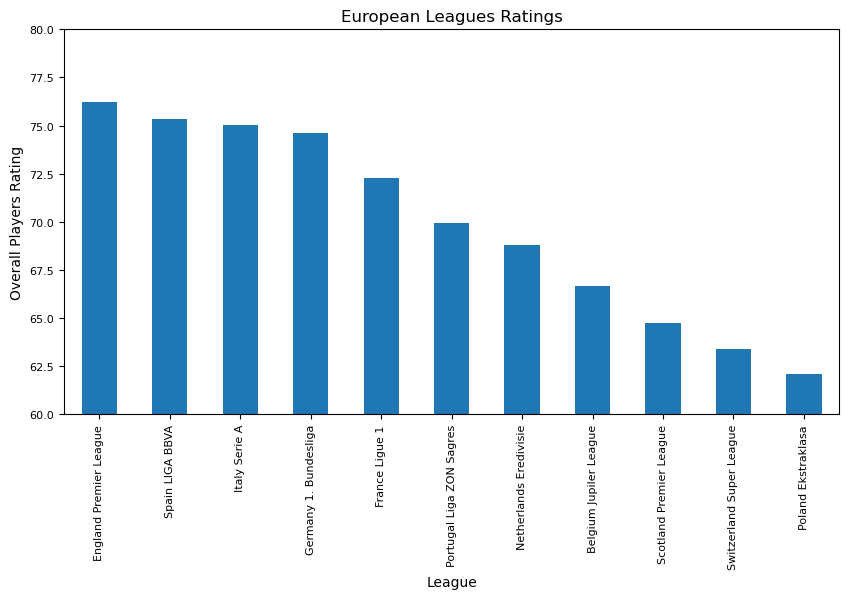

In [25]:
league_rating.plot(figsize= (10,5), xlabel='League', ylabel='Overall Players Rating', fontsize=8, kind='bar', legend=None, ylim=(60,80), title= 'European Leagues Ratings')
plt.xticks(rotation=90)



The premier league is the league with the best average rated players, then comes the spanish league.

In [26]:
team_rating = df_league_rating.copy()
team_rating.drop(team_rating.columns[[0,1,2,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)


In [27]:
team_rating = team_rating.groupby(by='Teams').mean()
team_rating.sort_values('overall_rating', ascending=False, inplace=True)
team_rating.head(20)

,overall_rating
Teams,
FC Barcelona,83.848045
Real Madrid CF,83.489522
Chelsea,82.586136
FC Bayern Munich,82.293754
Manchester City,81.613367
Manchester United,81.145202
Juventus,80.917279
Inter,80.527556
Arsenal,80.365431


<AxesSubplot: title={'center': 'Top 20 European Teams'}, xlabel='Teams', ylabel='Overall Rating'>

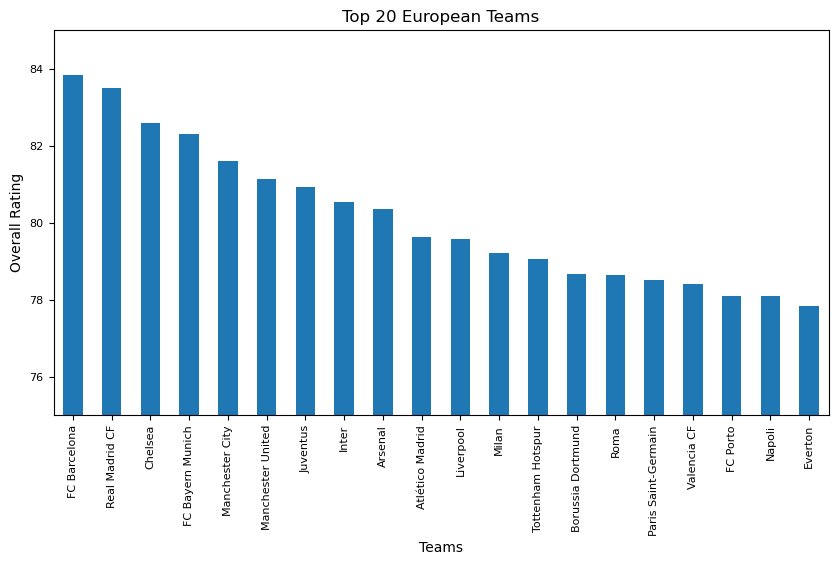

In [28]:
team_rating.head(20).plot(figsize= (10,5), ylabel='Overall Rating', fontsize=8, kind='bar', ylim=(75,85), legend=None, title= 'Top 20 European Teams')


FC Barcelona is the team with the best average rated players, then comes Real Madrid CF.

### Top rated leagues and Top  rated teams between 2008-2016.

Text(0.5, 1.0, 'Total Matches Played')

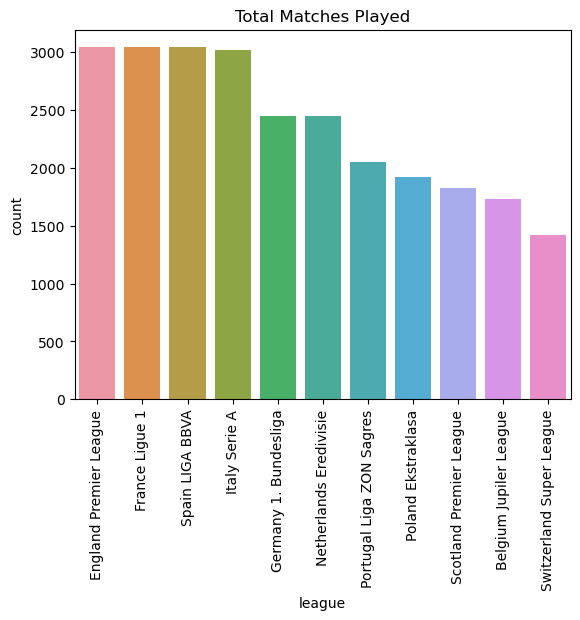

In [29]:
sb.countplot(data=df_leaguematches,x='league', order = df_leaguematches['league'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Total Matches Played')

Through the period from 2007 to 2016 the English premier league , france ligue 1, Italy Serie A, and Spain LIGA BBVA are the leagues with most matches and same number of matches. The rest of the leagues differ in the number of matches played with the switzerland league having the least number of matches.

In [30]:

df_league_goals = df_leaguematches.drop(['home_team','away_team'],axis=1)
df_league_goals ['total_goals'] = df_league_goals['home_team_goal']+ df_league_goals['away_team_goal']
df_league_goals.groupby(by='league').sum().sort_values(by='total_goals', ascending=False)

,home_team_goal,away_team_goal,total_goals
league,,,
Spain LIGA BBVA,4959,3453,8412
England Premier League,4715,3525,8240
Italy Serie A,4528,3367,7895
Netherlands Eredivisie,4357,3185,7542
France Ligue 1,4265,3162,7427
Germany 1. Bundesliga,3982,3121,7103
Portugal Liga ZON Sagres,2890,2311,5201
Belgium Jupiler League,2781,2060,4841
Scotland Premier League,2607,2197,4804


This dataframe shows the total goals scored in each leage from 2008 to 2016 taking into consideration also the home and away goals.

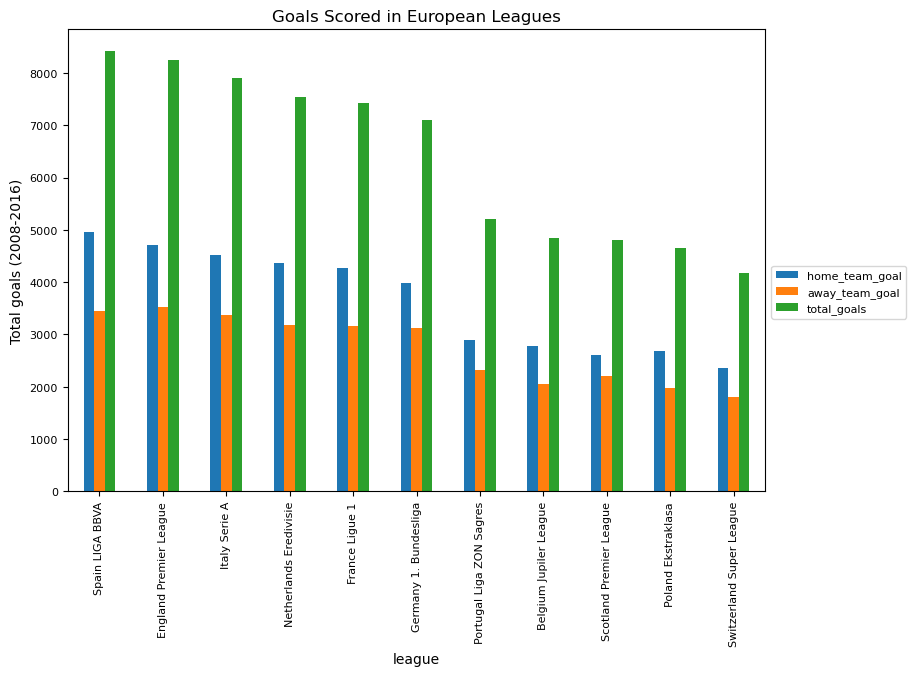

In [31]:
df_league_goals.groupby(by='league').sum().sort_values(by='total_goals', ascending=False).plot(figsize= (9,6), ylabel='Total goals (2008-2016)', fontsize=8, kind='bar', title= 'Goals Scored in European Leagues')
plt.legend(fontsize= 8, bbox_to_anchor=(1.21,.5))

<AxesSubplot: title={'center': 'Average Goals Scored in European Leagues'}, xlabel='league', ylabel='Averag Goals Per Match (2008-2016)'>

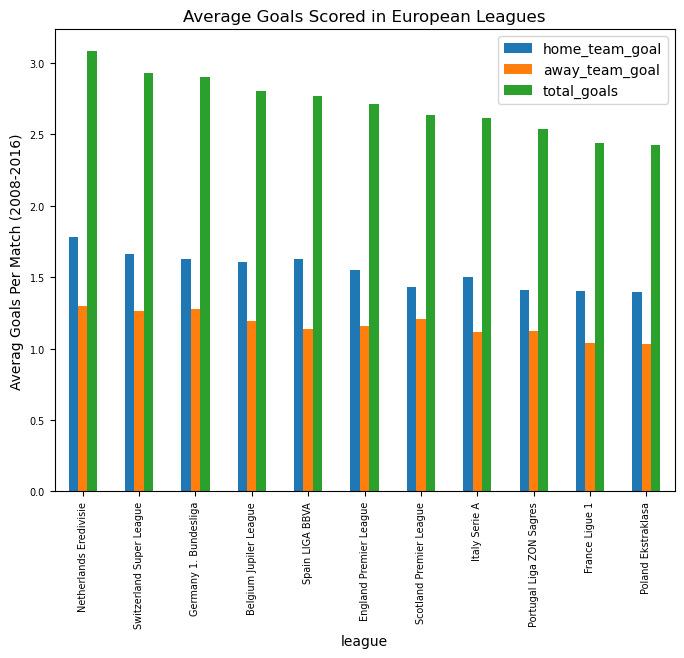

In [32]:

df_avg_goals_permatch = df_league_goals.groupby(by=['league']).mean()
df_avg_goals_permatch.sort_values(by='total_goals',ascending= False).plot(kind='bar',ylabel='Averag Goals Per Match (2008-2016)' ,figsize=(8,6), fontsize=7,title= 'Average Goals Scored in European Leagues')


Since the number of matches and teams vary from one league to the other, it might be better to look at the average goals per match for each league instead of the total number of goals. The above graph shows the averge goals scored in a match for each league. The Netherlands Eredivise league stands out to be the most league with average goals per match

### Top teams between 2008-2016 with the most goal differnce playing home, away and in total.
Goal difference is the difference between goals scored and goals conceded.

In [33]:
df_avg_team_home_goals = df_leaguematches.groupby(by='home_team').mean()
df_avg_team_home_goals['avg_home_goals_difference'] = df_avg_team_home_goals['home_team_goal']- df_avg_team_home_goals['away_team_goal']
df_avg_team_home_goals.rename(columns={'home_team_goal':'avg_home_goals_scored','away_team_goal':'avg_home_goals_conceded'}, inplace=True)
df_avg_team_home_goals.sort_values(by='avg_home_goals_difference', ascending=False, inplace=True)
df_avg_team_home_goals.head(20)

,avg_home_goals_scored,avg_home_goals_conceded,avg_home_goals_difference
home_team,,,
FC Barcelona,3.256579,0.664474,2.592105
Real Madrid CF,3.322368,0.967105,2.355263
FC Bayern Munich,2.808824,0.705882,2.102941
Ajax,2.647059,0.573529,2.073529
Celtic,2.559211,0.578947,1.980263
SL Benfica,2.588710,0.661290,1.927419
FC Porto,2.379032,0.524194,1.854839
PSV,2.720588,0.926471,1.794118
Rangers,2.328947,0.736842,1.592105


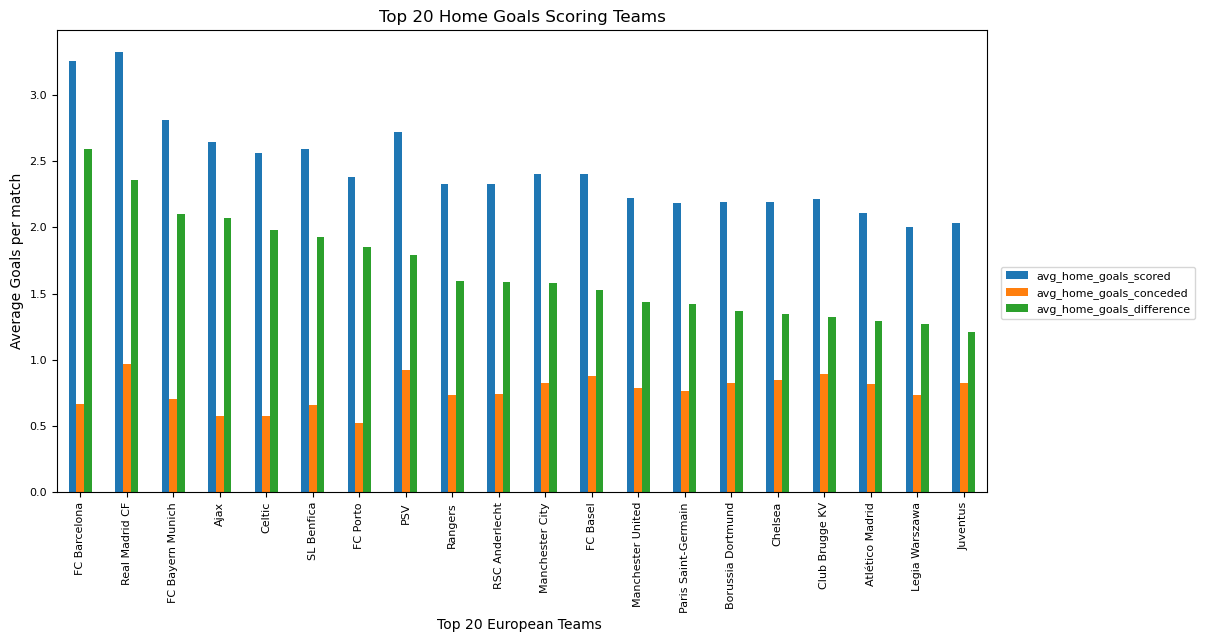

In [34]:
df_avg_team_home_goals.head(20).plot(figsize= (12,6), fontsize=8, xlabel='Top 20 European Teams ', ylabel='Average Goals per match', kind='bar', title= 'Top 20 Home Goals Scoring Teams' )
plt.legend(fontsize= 8, bbox_to_anchor=(1.23,.5))


In this graph, the top 20 teams with the highest average goals difference per match at home are shown.(Goals difference = Goals scored - Goals conceded) 

In [35]:
df_avg_team_away_goals = df_leaguematches.groupby(by='away_team').mean()
df_avg_team_away_goals['avg_away_goals_difference'] = df_avg_team_away_goals['away_team_goal']- df_avg_team_away_goals['home_team_goal']
df_avg_team_away_goals.sort_values(by='avg_away_goals_difference', ascending=False, inplace=True)
df_avg_team_away_goals.rename(columns={'away_team_goal':'avg_away_goals_scored','home_team_goal':'avg_away_goals_conceded'}, inplace=True)
first_column = df_avg_team_away_goals.pop('avg_away_goals_scored')
df_avg_team_away_goals.insert(0,'avg_away_goals_sored',first_column)
df_avg_team_away_goals.head(20)

,avg_away_goals_sored,avg_away_goals_conceded,avg_away_goals_difference
away_team,,,
FC Barcelona,2.328947,0.861842,1.467105
FC Porto,1.983871,0.774194,1.209677
Real Madrid CF,2.223684,1.032895,1.190789
Rangers,1.934211,0.750000,1.184211
SL Benfica,1.991935,0.838710,1.153226
FC Bayern Munich,1.992647,0.845588,1.147059
Celtic,2.013158,0.888158,1.125000
Ajax,2.110294,1.161765,0.948529
PSV,2.073529,1.235294,0.838235


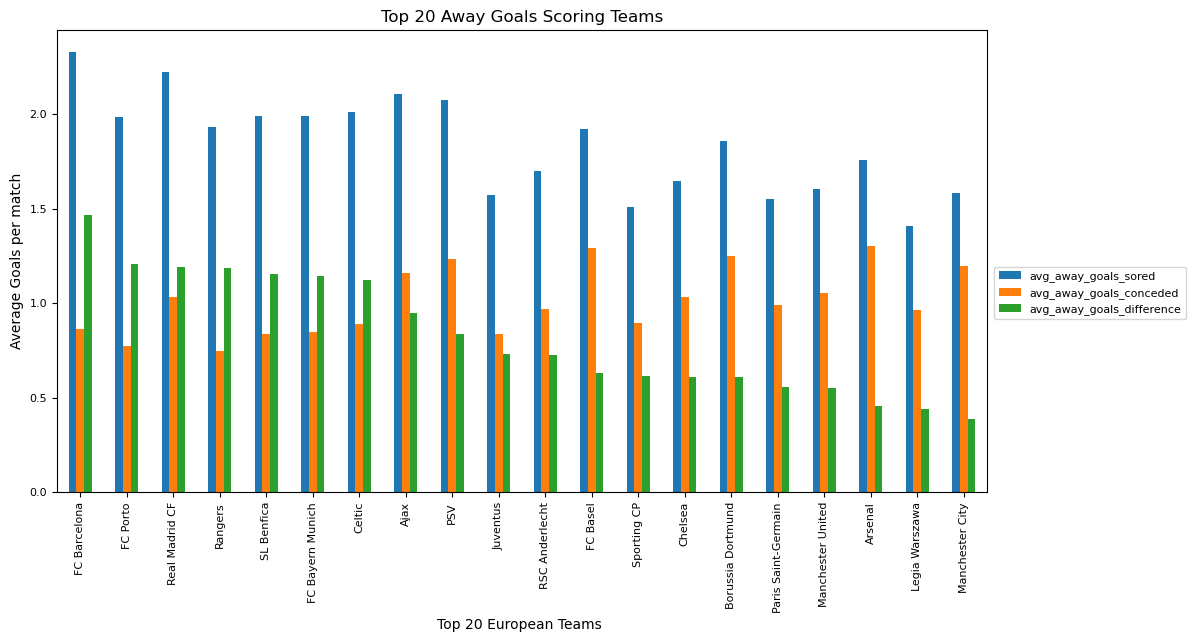

In [36]:
df_avg_team_away_goals.head(20).plot(figsize= (12,6), fontsize=8, xlabel='Top 20 European Teams ', ylabel='Average Goals per match', kind='bar', title= 'Top 20 Away Goals Scoring Teams')
plt.legend(fontsize= 8, bbox_to_anchor=(1.22,.5))

In this graph, the top 20 teams with the highest average goals difference per match away from home are shown (Goals difference = Goals scored - Goals conceded). 

In [37]:
df_team_home_goals = df_leaguematches.groupby(by='home_team').sum()
df_team_home_goals['home_goals_difference'] = df_team_home_goals['home_team_goal']- df_team_home_goals['away_team_goal']
df_team_home_goals.sort_values(by='home_team', ascending=True, inplace=True)
df_team_home_goals.rename(columns={'home_team_goal':'home_goals_scored','away_team_goal':'home_goals_conceded'}, inplace=True)
df_team_home_goals.head(20)

,home_goals_scored,home_goals_conceded,home_goals_difference
home_team,,,
1. FC Kaiserslautern,37,47,-10
1. FC Köln,116,139,-23
1. FC Nürnberg,108,118,-10
1. FSV Mainz 05,171,129,42
AC Ajaccio,64,77,-13
AC Arles-Avignon,14,31,-17
AC Bellinzona,74,97,-23
ADO Den Haag,204,200,4
AJ Auxerre,98,72,26


In [38]:
df_team_away_goals = df_leaguematches.groupby(by='away_team').sum()
df_team_away_goals['away_goals_difference'] = df_team_away_goals['away_team_goal']- df_team_away_goals['home_team_goal']
df_team_away_goals.sort_values(by='away_team', ascending=True, inplace=True)
df_team_away_goals.rename(columns={'away_team_goal':'away_goals_scored','home_team_goal':'away_goals_conceded'}, inplace=True)
first_column = df_team_away_goals.pop('away_goals_scored')
df_team_away_goals.insert(0,'away_goals_sored',first_column)
df_team_away_goals.head(20)

,away_goals_sored,away_goals_conceded,away_goals_difference
away_team,,,
1. FC Kaiserslautern,35,58,-23
1. FC Köln,110,172,-62
1. FC Nürnberg,85,151,-66
1. FSV Mainz 05,149,190,-41
AC Ajaccio,52,107,-55
AC Arles-Avignon,7,39,-32
AC Bellinzona,54,121,-67
ADO Den Haag,162,268,-106
AJ Auxerre,70,90,-20


In [39]:
df_avg_team_goals_per_match = pd.DataFrame(columns=('avg_goals_scored_per_match','avg_goals_conceded_per_match','avg_goals_difference_per_match'))

In [40]:

df_avg_team_goals_per_match['avg_goals_scored_per_match'] = (df_avg_team_home_goals['avg_home_goals_scored'] + df_avg_team_away_goals['avg_away_goals_sored'])/2
df_avg_team_goals_per_match['avg_goals_conceded_per_match'] = (df_avg_team_home_goals['avg_home_goals_conceded'] + df_avg_team_away_goals['avg_away_goals_conceded'])/2
df_avg_team_goals_per_match['avg_goals_difference_per_match'] = (df_avg_team_home_goals['avg_home_goals_difference'] + df_avg_team_away_goals['avg_away_goals_difference'])/2
df_avg_team_goals_per_match.sort_values(by='avg_goals_difference_per_match', ascending=False,inplace=True)
df_avg_team_goals_per_match.round(decimals=2).head(20)

,avg_goals_scored_per_match,avg_goals_conceded_per_match,avg_goals_difference_per_match
FC Barcelona,2.79,0.76,2.03
Real Madrid CF,2.77,1.00,1.77
FC Bayern Munich,2.40,0.78,1.62
Celtic,2.29,0.73,1.55
SL Benfica,2.29,0.75,1.54
FC Porto,2.18,0.65,1.53
Ajax,2.38,0.87,1.51
Rangers,2.13,0.74,1.39
PSV,2.40,1.08,1.32
RSC Anderlecht,2.01,0.86,1.16


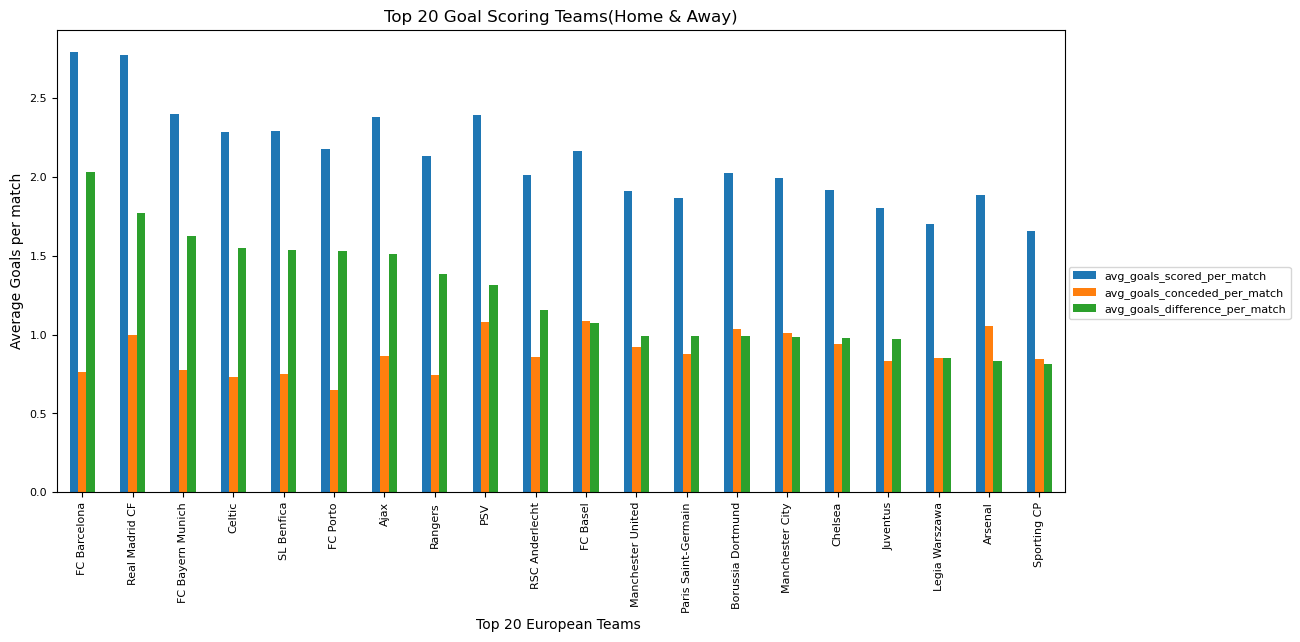

In [41]:
df_avg_team_goals_per_match.head(20).plot(figsize= (13,6), fontsize=8, xlabel='Top 20 European Teams ', ylabel='Average Goals per match', kind='bar',title= 'Top 20 Goal Scoring Teams(Home & Away)')
plt.legend(fontsize= 8, bbox_to_anchor=(1.23,.5))

In this graph, the top 20 teams with the highest average goals difference per match are shown (Goals difference = Goals scored - Goals conceded). 

### Top teams between 2008-2016 with the most number and percentage of match wins playing home, away and in total.

In [42]:
df_leaguematches.head()

,league,season,home_team,away_team,home_team_goal,away_team_goal
0,Belgium Jupiler League,2008/2009,KRC Genk,Beerschot AC,1,1
1,Belgium Jupiler League,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium Jupiler League,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium Jupiler League,2008/2009,KAA Gent,RAEC Mons,5,0
4,Belgium Jupiler League,2008/2009,FCV Dender EH,Standard de Liège,1,3


Next we want to find the top 20 teams with highest wins from 2008 till 2016.
A function will be used to calculate the home and away wins, losses, and draws.

In [43]:
def home_match_result(dfrow):
    
#  This function calculates the result of a match for home team.

    if dfrow['home_team_goal'] == dfrow['away_team_goal']:
        result = 'draw'
    elif dfrow['home_team_goal'] > dfrow['away_team_goal']:
        result = 'win'
    else:
        result = 'loss'
    return result


def away_match_result(dfrow):
    
#  This function calculates the result of a match for home team.

    if dfrow['home_team_goal'] == dfrow['away_team_goal']:
        result = 'draw'
    elif dfrow['home_team_goal'] > dfrow['away_team_goal']:
        result = 'loss'
    else:
        result = 'win'
    return result




In [44]:
df_leaguematches['home_team_result'] = df_leaguematches.apply(home_match_result, axis=1)
df_leaguematches['away_team_result'] = df_leaguematches.apply(away_match_result, axis=1)
df_leaguematches.head()

,league,season,home_team,away_team,home_team_goal,away_team_goal,home_team_result,away_team_result
0,Belgium Jupiler League,2008/2009,KRC Genk,Beerschot AC,1,1,draw,draw
1,Belgium Jupiler League,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0,draw,draw
2,Belgium Jupiler League,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3,loss,win
3,Belgium Jupiler League,2008/2009,KAA Gent,RAEC Mons,5,0,win,loss
4,Belgium Jupiler League,2008/2009,FCV Dender EH,Standard de Liège,1,3,loss,win


In this table , we have the result for each match and the team that won each match.

In [45]:
df_home_wins = df_leaguematches[['home_team','home_team_result']].copy()
df_home_wins = df_home_wins[df_home_wins['home_team_result']=='win'].groupby(by='home_team').count()
df_home_wins = df_home_wins.rename(columns={'home_team_result':'home_team_wins'})
df_home_wins.sort_values(by='home_team', ascending=False,inplace= True)
df_home_wins.reset_index(inplace=True)

df_home_draws= df_leaguematches[['home_team','home_team_result']].copy()
df_home_draws= df_home_draws[df_home_draws['home_team_result']=='draw'].groupby(by='home_team').count()
df_home_draws = df_home_draws.rename(columns={'home_team_result':'home_team_draws'})
df_home_draws.sort_values(by='home_team', ascending=False,inplace= True)
df_home_draws.reset_index(inplace=True)

df_home_losses= df_leaguematches[['home_team','home_team_result']].copy()
df_home_losses= df_home_losses[df_home_losses['home_team_result']=='loss'].groupby(by='home_team').count()
df_home_losses= df_home_losses.rename(columns={'home_team_result':'home_team_losses'})
df_home_losses.sort_values(by='home_team', ascending=False, inplace= True)
df_home_losses.reset_index(inplace=True)

df_home_results = pd.merge(pd.merge(df_home_wins,df_home_draws,how='outer', on='home_team'),df_home_losses,how='outer',on='home_team')
df_home_results.fillna(0,inplace=True)
df_home_results[['home_team_wins','home_team_draws']]= df_home_results[['home_team_wins','home_team_draws']].astype(int)
df_home_results.set_index('home_team',inplace=True)
df_home_results.sort_values(by="home_team_wins", ascending=False, inplace=True)

3 dataframes are made in which:
- df_home_wins contains all the teams with the number of home wins for each team.
- df_home_draws contains all the teams with the number of home draws for each team.
- df_home_losses contains all the teams with the number of home losses for each team.

Then df_home_result is used to join all three dataframes together.



In [46]:

df_home_results['percentage_home_team_wins']= ((df_home_results['home_team_wins'])/(df_home_results.iloc[:,[0,1,2]].sum(axis=1)))*100
df_home_results['percentage_home_team_draws']= ((df_home_results['home_team_draws'])/(df_home_results.iloc[:,[0,1,2]].sum(axis=1)))*100
df_home_results['percentage_home_team_losses']= ((df_home_results['home_team_losses'])/(df_home_results.iloc[:,[0,1,2]].sum(axis=1)))*100

df_home_results.sort_values(by="percentage_home_team_wins", ascending=False, inplace=True)
df_home_results.head(20)

,home_team_wins,home_team_draws,home_team_losses,percentage_home_team_wins,percentage_home_team_draws,percentage_home_team_losses
home_team,,,,,,
FC Barcelona,131,12,9,86.184211,7.894737,5.921053
Real Madrid CF,129,11,12,84.868421,7.236842,7.894737
SL Benfica,102,15,7,82.258065,12.096774,5.645161
FC Porto,102,16,6,82.258065,12.903226,4.838710
FC Bayern Munich,109,14,13,80.147059,10.294118,9.558824
Celtic,120,23,9,78.947368,15.131579,5.921053
PSV,105,18,13,77.205882,13.235294,9.558824
Manchester United,116,16,20,76.315789,10.526316,13.157895
Ajax,103,24,9,75.735294,17.647059,6.617647


The percentage home wins,losse, and draws for each team is calculated by the following formula:
number of (home wins, home losses, or home draws)/ Total home mathces(wins+draws+losses) 

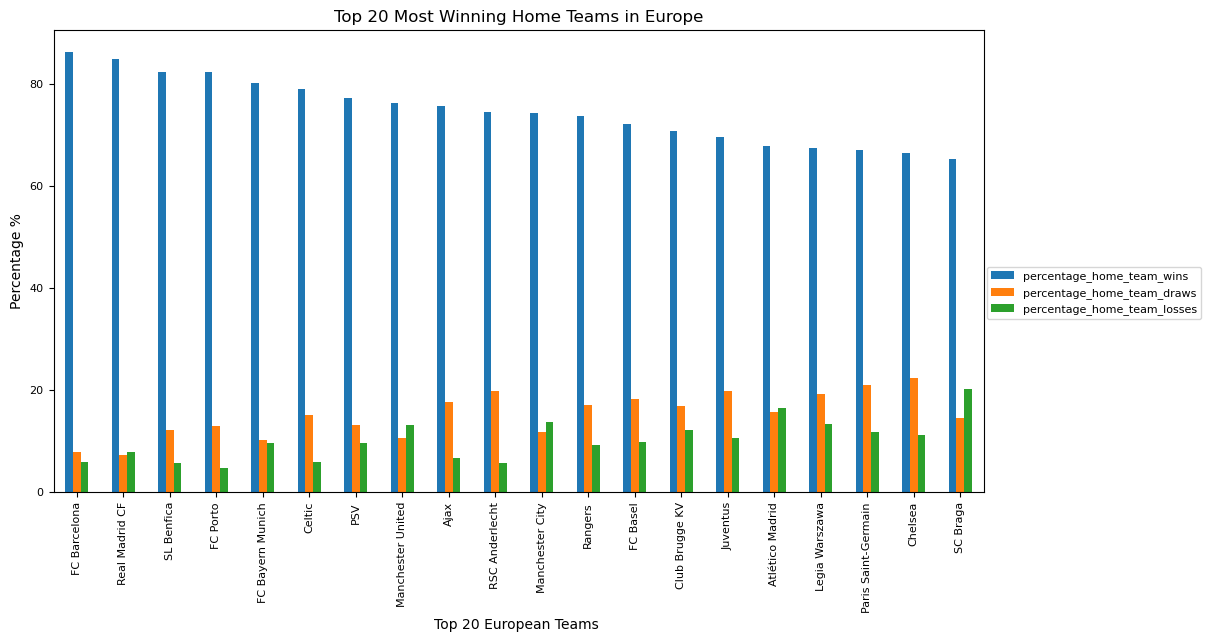

In [47]:
df_home_results.iloc[:,[3,4,5]].head(20).plot(figsize= (12,6), fontsize=8, xlabel='Top 20 European Teams ', ylabel='Percentage %', kind='bar', title= 'Top 20 Most Winning Home Teams in Europe')
plt.legend(fontsize= 8, bbox_to_anchor=(1.24,.5))

In [48]:

df_away_wins = df_leaguematches[['away_team','away_team_result']].copy()
df_away_wins=df_away_wins[df_away_wins['away_team_result']=='win'].groupby(by='away_team').count()
df_away_wins= df_away_wins.rename(columns={'away_team_result':'away_team_wins'})
df_away_wins.sort_values(by='away_team', ascending=False, inplace=True)
df_away_wins.reset_index(inplace=True)


df_away_losses = df_leaguematches[['away_team','away_team_result']].copy()
df_away_losses=df_away_losses[df_away_losses['away_team_result']=='loss'].groupby(by='away_team').count()
df_away_losses= df_away_losses.rename(columns={'away_team_result':'away_team_losses'})
df_away_losses.sort_values(by='away_team', ascending=False, inplace=True)
df_away_losses.reset_index(inplace=True)

df_away_draws = df_leaguematches[['away_team','away_team_result']].copy()
df_away_draws=df_away_draws[df_away_draws['away_team_result']=='draw'].groupby(by='away_team').count()
df_away_draws= df_away_draws.rename(columns={'away_team_result':'away_team_draws'})
df_away_draws.sort_values(by='away_team', ascending=False, inplace=True)
df_away_draws.reset_index(inplace=True)


df_away_results = pd.merge(pd.merge(df_away_wins,df_away_draws,how='outer', on='away_team'),df_away_losses,how='outer',on='away_team')
df_away_results.fillna(0,inplace=True)
df_away_results[['away_team_wins','away_team_draws']]= df_away_results[['away_team_wins','away_team_draws']].astype(int)
df_away_results.set_index('away_team',inplace=True)
df_away_results.sort_values(by="away_team_wins", ascending=False, inplace=True)




Same steps are made to the away mathces in which 3 dataframes are made in which:
- df_away_wins contains all the teams with the number of home wins for each team.
- df_away_draws contains all the teams with the number of home draws for each team.
- df_away_losses contains all the teams with the number of home losses for each team.

Then df_away_result is used to join all three dataframes together.

In [49]:
df_away_results['percentage_away_team_wins']= ((df_away_results['away_team_wins'])/(df_away_results.iloc[:,[0,1,2]].sum(axis=1)))*100
df_away_results['percentage_away_team_draws']= ((df_away_results['away_team_draws'])/(df_away_results.iloc[:,[0,1,2]].sum(axis=1)))*100
df_away_results['percentage_away_team_losses']= ((df_away_results['away_team_losses'])/(df_away_results.iloc[:,[0,1,2]].sum(axis=1)))*100

df_away_results.sort_values(by="percentage_away_team_wins", ascending=False, inplace=True)


df_away_results.head(20)

,away_team_wins,away_team_draws,away_team_losses,percentage_away_team_wins,percentage_away_team_draws,percentage_away_team_losses
away_team,,,,,,
Rangers,52,12,12,68.421053,15.789474,15.789474
FC Barcelona,103,31,18,67.763158,20.394737,11.842105
SL Benfica,83,21,20,66.935484,16.935484,16.129032
FC Porto,81,26,17,65.322581,20.967742,13.709677
Real Madrid CF,99,25,28,65.131579,16.447368,18.421053
Celtic,98,27,27,64.473684,17.763158,17.763158
FC Bayern Munich,84,30,22,61.764706,22.058824,16.176471
Ajax,78,35,23,57.352941,25.735294,16.911765
Juventus,84,36,30,56.000000,24.000000,20.000000


The percentage away wins,losse, and draws for each team is calculated by the following formula:
number of (away wins, away losses, or away draws)/ Total away mathces(wins+draws+losses) 

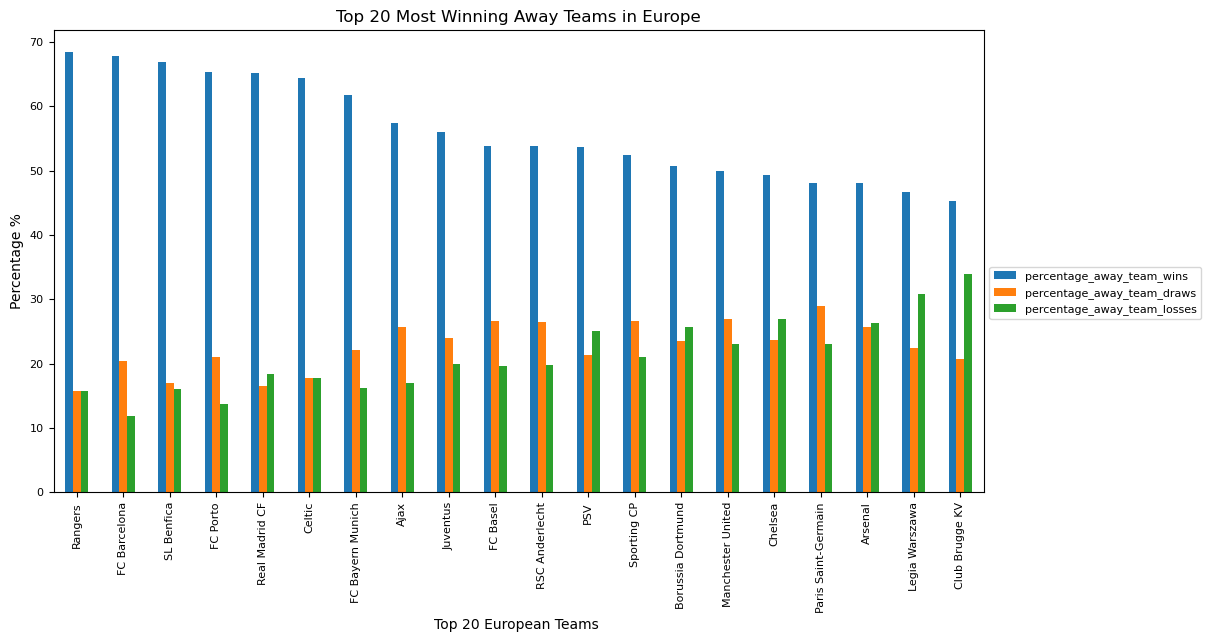

In [50]:
df_away_results.iloc[:,[3,4,5]].head(20).plot(figsize= (12,6), fontsize=8, xlabel='Top 20 European Teams ', ylabel='Percentage %', kind='bar',title= 'Top 20 Most Winning Away Teams in Europe')
plt.legend(fontsize= 8, bbox_to_anchor=(1.24,.5))

In [51]:
df_total_results = pd.DataFrame(columns=('percentage_team_wins','percentage_team_draws','perentage_team_losses'))

A new dataframe 'df_total_results' is made to get the total percentage of wins (home & away)

In [63]:
df_total_results['percentage_team_wins'] = ((df_home_results['percentage_home_team_wins'] + df_away_results['percentage_away_team_wins'])/2)
df_total_results['percentage_team_draws'] = ((df_home_results['percentage_home_team_draws'] + df_away_results['percentage_away_team_draws'])/2)
df_total_results['perentage_team_losses'] = ((df_home_results['percentage_home_team_losses'] + df_away_results['percentage_away_team_losses'])/2)
df_total_results.sort_values(by='percentage_team_wins', ascending=False,inplace=True)
df_total_results.round(decimals=3).head(20)

,percentage_team_wins,percentage_team_draws,perentage_team_losses
FC Barcelona,76.974,14.145,8.882
Real Madrid CF,75.000,11.842,13.158
SL Benfica,74.597,14.516,10.887
FC Porto,73.790,16.935,9.274
Celtic,71.711,16.447,11.842
Rangers,71.053,16.447,12.500
FC Bayern Munich,70.956,16.176,12.868
Ajax,66.544,21.691,11.765
PSV,65.441,17.279,17.279
RSC Anderlecht,64.151,23.113,12.736


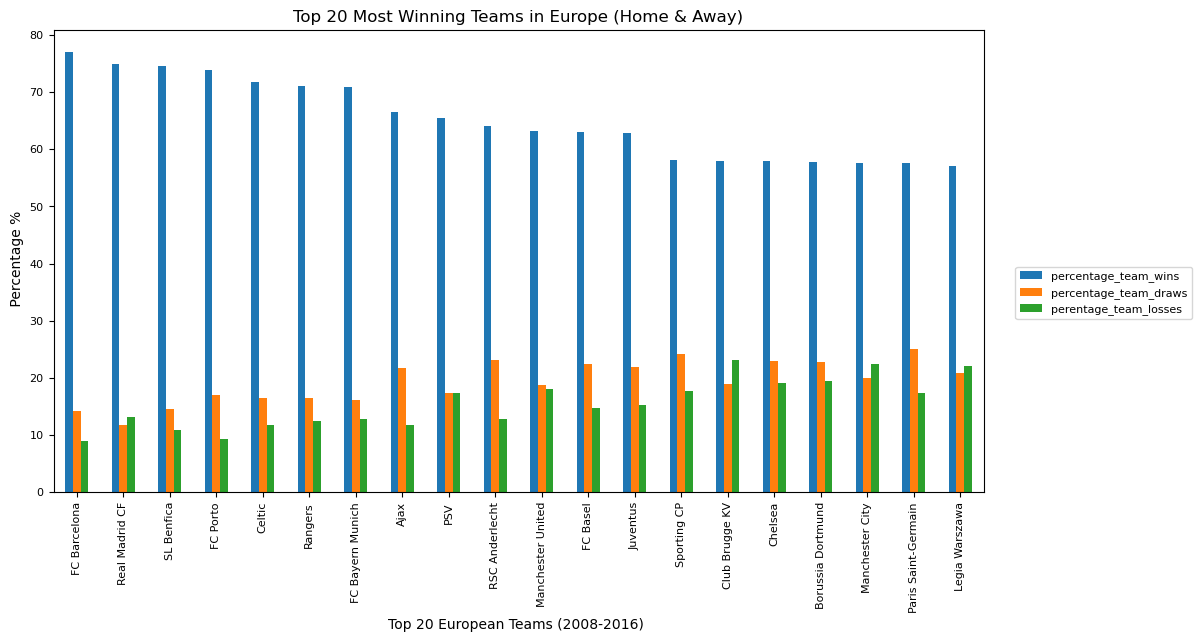

In [64]:
df_total_results.round(decimals=3).head(20).plot(figsize= (12,6), fontsize=8, xlabel='Top 20 European Teams (2008-2016) ', ylabel=' Percentage %', kind='bar', title= 'Top 20 Most Winning Teams in Europe (Home & Away)')
plt.legend(fontsize= 8, bbox_to_anchor=(1.23,.5))

FC Barcelona stands out to be the team with the most percentage of match wins. 

In [65]:
#Create a dataframe that has team name and corresponding league.
df_teamleague = df_league_rating.groupby(['Teams']).agg({'name':lambda x: x.value_counts().index[0]})


In [66]:
#Create a dataframe that joins team resutls, overall rating and corresponding league.
df_ratings_results = df_total_results.join(team_rating)
df_ratings_results =df_ratings_results.join(df_teamleague)
df_ratings_results.drop(df_ratings_results[df_ratings_results['name']=='Switzerland Super League'].index, inplace=True)

In [67]:
df_ratings_results

,percentage_team_wins,percentage_team_draws,perentage_team_losses,overall_rating,name
FC Barcelona,76.973684,14.144737,8.881579,83.848045,Spain LIGA BBVA
Real Madrid CF,75.000000,11.842105,13.157895,83.489522,Spain LIGA BBVA
SL Benfica,74.596774,14.516129,10.887097,77.815271,Portugal Liga ZON Sagres
FC Porto,73.790323,16.935484,9.274194,78.107754,Portugal Liga ZON Sagres
Celtic,71.710526,16.447368,11.842105,72.206429,Scotland Premier League
...,...,...,...,...,...
FC Dordrecht,11.764706,23.529412,64.705882,64.227861,Netherlands Eredivisie
SpVgg Greuther Fürth,11.764706,26.470588,61.764706,69.324599,Germany 1. Bundesliga
DSC Arminia Bielefeld,11.764706,47.058824,41.176471,70.008021,Germany 1. Bundesliga
AC Arles-Avignon,7.894737,28.947368,63.157895,66.511510,France Ligue 1


Text(0.5, 1.0, 'Percentage Team Wins Vs Overall Rating ')

<Figure size 1300x800 with 0 Axes>

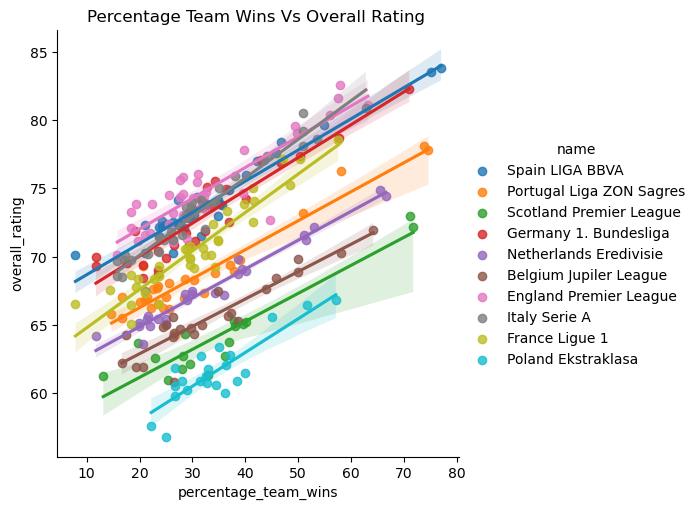

In [68]:
plt.figure(figsize=(13,8))
sb.lmplot(data=df_ratings_results, x='percentage_team_wins', y='overall_rating', hue='name', palette='tab10')
plt.title('Percentage Team Wins Vs Overall Rating ')

This graph shows that the overall rating of a team is directy proportional to the percentage the team wins in all the European leagues.

<a id='conclusions'></a>
## Conclusions



There are many more interesting facts and information that can be investigated and analyzed from the database we used. Although there are alot of missing data and null values, but most probably it did not affect much the analysis results.

In conlusion, we can summarize our findings for the European Leagues between the years 2008-2016 in the following :
- The number of matches differ in each of the leagues with the english, spanish, Italian, and frecnh leagues equally having the most number of mathces.
- The best European league in terms of the league overall rating of the players is the Premier League then the Spanish Liga BBVA league.
- The most agverage goalscoring league per match is the Netherlands Eredevise leaue.
- The best European teams in terms of winning percentages and goals difference (Home & Away) are FC Barcelona and Real Madrid CF.
- The best 3 overall rated players are Lionel Messi, Cristiano Ronaldo, and Zlatan Ibrahimovic.

### Limitations of the study:
- There are alot of missing players on many of the matches played. Therefore, the average of the team rating is used to fill the missing players values in a certain team.
- Sonme matches played have all the players' rating  missing, in this case, the record is deleted.
- Since the number of matches in many of the  leagues is different, comparison between teams by counting win/loss is not accurate, therefore percentages of win/loss is used.
